In [1]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

import keras
from tensorflow.keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

import time
from datetime import timedelta

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.data import Dataset

from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adagrad


In [2]:
DATA_PATH = "../../Data/"
IMG_SIZE = (224, 224)
IMAGES_PATH_SEPARATED = DATA_PATH+"HAM10000_images_separated/"
IMAGES_PATH_VALIDATION = DATA_PATH+"HAM10000_images_separated_validation/"

In [3]:
batch_size = 64
generator = ImageDataGenerator(validation_split=0.2)
train_data = generator.flow_from_directory( 
        subset="training",
        directory=IMAGES_PATH_SEPARATED,
        target_size=IMG_SIZE,
        batch_size=batch_size
)
test_data = generator.flow_from_directory( 
        subset="validation",
        directory=IMAGES_PATH_SEPARATED,
        target_size=IMG_SIZE,
        batch_size=batch_size
)

Found 7212 images belonging to 7 classes.
Found 1798 images belonging to 7 classes.


In [ ]:
# NOT ENOUGH MEMORY (RAM) 
# FIXED using ImageDataGenerator and flow_from_directory
'''
image_data, label_data = [], []
for images, labels in tqdm(image_ds.as_numpy_iterator()):
    for i in range(len(labels)):
        image_data.append(images[i])
        label_data.append(labels[i])
''';


105it [00:06,  8.84it/s]

In [4]:
def print_training_history(history: keras.callbacks.History) -> None:
    
    epochs = len(history.history['loss'])
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.xlabel("Epochs")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.xlabel("Epochs")
    plt.title("Training and Validation Loss")
    plt.show()

In [5]:
def evaluate_model(model: Sequential, train_ds: Dataset, test_ds: Dataset) -> None:
    acc_value = model.evaluate(train_ds, verbose=0)[1]
    val_acc_value = model.evaluate(test_ds, verbose=0)[1]
    print("Model Accuracy      : {0:.4f}".format(acc_value))
    print("Validation Accuracy : {0:.4f}".format(val_acc_value))

## VGG16

In [22]:
# Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False # Not trainable weights
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
'''
# Not Fully tested but 5 epochs were slow but steady 73-73
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    base_model,
    layers.BatchNormalization(momentum=0.9),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),    
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(7, activation="softmax")
])

optimizer = Adagrad() # Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_loss', mode='min', patience=5,  
                   restore_best_weights=True, min_delta=0.001)

history = model.fit(train_data, validation_data=test_data, 
                    batch_size=batch_size, epochs=50, callbacks=[es])
epochs = len(history.history['loss'])
print("Epoch Length        : {0}".format(epochs))
''';

In [31]:
# Measure time
start_time = time.time()

epochs = 25

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    base_model,
    
    layers.Flatten(),
    layers.BatchNormalization(),
    
    layers.Dense(256, activation="relu"),    
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(128, activation="relu"),    
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(64, activation="relu"),    
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(7, activation="softmax")
])


optimizer = K.optimizers.Adam(learning_rate=0.0001) # RMSprop(learning_rate=0.00002) # Adagrad() # Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_loss', mode='min', patience=3,  
                   restore_best_weights=True, min_delta=0.01)

history = model.fit(train_data, validation_data=test_data, 
                    batch_size=batch_size, epochs=epochs, callbacks=[es])
epochs = len(history.history['loss'])

print("Epoch Length        : {0}".format(epochs))
print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))

model.save("output\keras_models\skin_classifier_VGG16_{0}.keras".format(epochs))

# VGG16 6 25 epochs ADAM 74/71

Epoch 1/25
113/113 [==============================] - 379s 3s/step - loss: 2.2654 - accuracy: 0.2420 - val_loss: 2.7518 - val_accuracy: 0.1135
Epoch 2/25
113/113 [==============================] - 387s 3s/step - loss: 2.0654 - accuracy: 0.3125 - val_loss: 2.5655 - val_accuracy: 0.1112
Epoch 3/25
113/113 [==============================] - 396s 4s/step - loss: 1.9136 - accuracy: 0.3640 - val_loss: 1.9964 - val_accuracy: 0.1652
Epoch 4/25
113/113 [==============================] - 391s 3s/step - loss: 1.7851 - accuracy: 0.4088 - val_loss: 1.6428 - val_accuracy: 0.5884
Epoch 5/25
113/113 [==============================] - 391s 3s/step - loss: 1.6793 - accuracy: 0.4584 - val_loss: 1.3732 - val_accuracy: 0.6852
Epoch 6/25
113/113 [==============================] - 390s 3s/step - loss: 1.5990 - accuracy: 0.4976 - val_loss: 1.2192 - val_accuracy: 0.7024
Epoch 7/25
113/113 [==============================] - 390s 3s/step - loss: 1.5018 - accuracy: 0.5370 - val_loss: 1.1375 - val_accuracy: 0.7091

In [23]:
# VGG16 5 24 epochs ADAM 84/73

Epoch 1/50
113/113 [==============================] - 541s 5s/step - loss: 2.2667 - accuracy: 0.2224 - val_loss: 1.7074 - val_accuracy: 0.5184
Epoch 2/50
113/113 [==============================] - 549s 5s/step - loss: 2.0110 - accuracy: 0.3192 - val_loss: 1.4518 - val_accuracy: 0.6379
Epoch 3/50
113/113 [==============================] - 533s 5s/step - loss: 1.8142 - accuracy: 0.4039 - val_loss: 1.2752 - val_accuracy: 0.6752
Epoch 4/50
113/113 [==============================] - 533s 5s/step - loss: 1.6718 - accuracy: 0.4752 - val_loss: 1.1670 - val_accuracy: 0.7019
Epoch 5/50
113/113 [==============================] - 531s 5s/step - loss: 1.5633 - accuracy: 0.5240 - val_loss: 1.0930 - val_accuracy: 0.7091
Epoch 6/50
113/113 [==============================] - 540s 5s/step - loss: 1.4240 - accuracy: 0.5811 - val_loss: 1.0255 - val_accuracy: 0.7208
Epoch 7/50
113/113 [==============================] - 530s 5s/step - loss: 1.3430 - accuracy: 0.6061 - val_loss: 0.9866 - val_accuracy: 0.7208

In [7]:
# VGG16 4 50 epochs 85/75

Epoch 1/50
113/113 [==============================] - 537s 5s/step - loss: 2.4303 - accuracy: 0.1943 - val_loss: 1.6920 - val_accuracy: 0.6352
Epoch 2/50
113/113 [==============================] - 500s 4s/step - loss: 2.2983 - accuracy: 0.2285 - val_loss: 1.4262 - val_accuracy: 0.6646
Epoch 3/50
113/113 [==============================] - 500s 4s/step - loss: 2.2130 - accuracy: 0.2612 - val_loss: 1.3620 - val_accuracy: 0.6557
Epoch 4/50
113/113 [==============================] - 502s 4s/step - loss: 2.1378 - accuracy: 0.2958 - val_loss: 1.3159 - val_accuracy: 0.6563
Epoch 5/50
113/113 [==============================] - 499s 4s/step - loss: 2.1031 - accuracy: 0.2987 - val_loss: 1.3059 - val_accuracy: 0.6529
Epoch 6/50
113/113 [==============================] - 497s 4s/step - loss: 2.0189 - accuracy: 0.3283 - val_loss: 1.2820 - val_accuracy: 0.6574
Epoch 7/50
113/113 [==============================] - 499s 4s/step - loss: 2.0054 - accuracy: 0.3393 - val_loss: 1.2597 - val_accuracy: 0.6557

In [99]:
# VGG16 3 30 epochs 79/73

Epoch 1/30
113/113 [==============================] - 634s 6s/step - loss: 2.4330 - accuracy: 0.1970 - val_loss: 2.0367 - val_accuracy: 0.0979
Epoch 2/30
113/113 [==============================] - 627s 6s/step - loss: 2.2702 - accuracy: 0.2336 - val_loss: 1.9116 - val_accuracy: 0.3165
Epoch 3/30
113/113 [==============================] - 626s 6s/step - loss: 2.1977 - accuracy: 0.2698 - val_loss: 1.7834 - val_accuracy: 0.4572
Epoch 4/30
113/113 [==============================] - 617s 5s/step - loss: 2.1477 - accuracy: 0.2794 - val_loss: 1.6636 - val_accuracy: 0.5228
Epoch 5/30
113/113 [==============================] - 630s 6s/step - loss: 2.0630 - accuracy: 0.3019 - val_loss: 1.5953 - val_accuracy: 0.5623
Epoch 6/30
113/113 [==============================] - 608s 5s/step - loss: 2.0243 - accuracy: 0.3210 - val_loss: 1.5495 - val_accuracy: 0.5923
Epoch 7/30
113/113 [==============================] - 601s 5s/step - loss: 1.9812 - accuracy: 0.3362 - val_loss: 1.4838 - val_accuracy: 0.6135

In [87]:
# VGG16    (BN+DO) 10 epochs 53/58 

Epoch 1/10
113/113 [==============================] - 578s 5s/step - loss: 2.4535 - accuracy: 0.1522 - val_loss: 2.1960 - val_accuracy: 0.1096
Epoch 2/10
113/113 [==============================] - 566s 5s/step - loss: 2.3157 - accuracy: 0.1886 - val_loss: 2.0931 - val_accuracy: 0.1096
Epoch 3/10
113/113 [==============================] - 588s 5s/step - loss: 2.2318 - accuracy: 0.2139 - val_loss: 1.9537 - val_accuracy: 0.1691
Epoch 4/10
113/113 [==============================] - 578s 5s/step - loss: 2.1558 - accuracy: 0.2385 - val_loss: 1.8120 - val_accuracy: 0.3515
Epoch 5/10
113/113 [==============================] - 566s 5s/step - loss: 2.1178 - accuracy: 0.2541 - val_loss: 1.7156 - val_accuracy: 0.4533
Epoch 6/10
113/113 [==============================] - 562s 5s/step - loss: 2.0559 - accuracy: 0.2778 - val_loss: 1.6535 - val_accuracy: 0.4933
Epoch 7/10
113/113 [==============================] - 561s 5s/step - loss: 2.0176 - accuracy: 0.2866 - val_loss: 1.6044 - val_accuracy: 0.5367

In [95]:
# VGG16 _2 (BN+D0) 10 epochs 63/64

Epoch 1/10
113/113 [==============================] - 746s 7s/step - loss: 2.4719 - accuracy: 0.1765 - val_loss: 1.7686 - val_accuracy: 0.3448
Epoch 2/10
113/113 [==============================] - 742s 7s/step - loss: 2.3209 - accuracy: 0.2277 - val_loss: 1.6732 - val_accuracy: 0.4127
Epoch 3/10
113/113 [==============================] - 706s 6s/step - loss: 2.2362 - accuracy: 0.2485 - val_loss: 1.5897 - val_accuracy: 0.4861
Epoch 4/10
113/113 [==============================] - 727s 6s/step - loss: 2.1926 - accuracy: 0.2682 - val_loss: 1.5082 - val_accuracy: 0.5423
Epoch 5/10
113/113 [==============================] - 700s 6s/step - loss: 2.1067 - accuracy: 0.2934 - val_loss: 1.4578 - val_accuracy: 0.5740
Epoch 6/10
113/113 [==============================] - 695s 6s/step - loss: 2.0741 - accuracy: 0.3074 - val_loss: 1.4153 - val_accuracy: 0.5912
Epoch 7/10
113/113 [==============================] - 691s 6s/step - loss: 2.0239 - accuracy: 0.3236 - val_loss: 1.3858 - val_accuracy: 0.6107

In [32]:
evaluate_model(model, train_data, test_data)

Model Accuracy      : 0.7488
Validation Accuracy : 0.7158


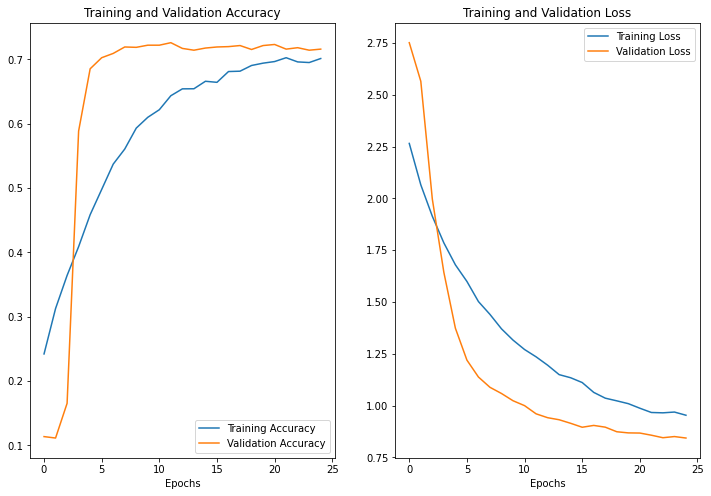

In [33]:
print_training_history(history)

In [ ]:
# VGG16    (BN+DO) 10 epochs 53/58 
# VGG16 _2 (BN+D0) 10 epochs 63/64

In [ ]:
'''
Epoch 6/50
544s 5s/step - loss: 0.3679 - accuracy: 0.8554 - val_loss: 1.2280 - val_accuracy: 0.7275
''';

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file="output/vgg16.png")

## ResNet50 (TEST) DO THIS AGAIN

In [34]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False # Not trainable weights
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [35]:
# Measure time
start_time = time.time()

epochs = 25

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    base_model,
    
    layers.Flatten(),
    layers.BatchNormalization(),
    
    layers.Dense(256, activation="relu"),    
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(128, activation="relu"),    
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(64, activation="relu"),    
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(7, activation="softmax")
])

# First run on the model the was no overfitting
# but overal model was weak, so decided to try differnt optimizer
# Small rate used for transfer learning

# Optimization algorithms in machine learning (especially in neural networks) 
# aim at minimizing an objective function (generally called loss or cost function), 
# which is intuitively the difference between the predicted data and the expected values

# Although ADAGRAD works well for sparse settings, 
# its performance has been observed to deteriorate in settings 
# where the loss functions are nonconvex and gradients are dense 
# due to the rapid decay of the learning rate in these settings 
# since it uses all the past gradients in the update

# Simply put, RMSprop uses an adaptive learning rate 
# instead of treating the learning rate as a hyperparameter. 
# This means that the learning rate changes over time
optimizer = K.optimizers.Adam(learning_rate=0.0001) # RMSprop(learning_rate=0.00002) # Adagrad() # Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_loss', mode='min', patience=3,  
                   restore_best_weights=True, min_delta=0.01)

history = model.fit(train_data, validation_data=test_data, 
                    batch_size=batch_size, epochs=epochs, callbacks=[es])
epochs = len(history.history['loss'])
print("Epoch Length        : {0}".format(epochs))
print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))

model.save("output\keras_models\skin_classifier_ResNet50_{0}.keras".format(epochs))

# ResNet50 25 epochs ADAM 75/71

Epoch 1/25
113/113 [==============================] - 392s 3s/step - loss: 2.3513 - accuracy: 0.2263 - val_loss: 3.9113 - val_accuracy: 0.1112
Epoch 2/25
113/113 [==============================] - 387s 3s/step - loss: 2.1094 - accuracy: 0.3114 - val_loss: 2.9425 - val_accuracy: 0.1135
Epoch 3/25
113/113 [==============================] - 396s 4s/step - loss: 1.9564 - accuracy: 0.3740 - val_loss: 1.7648 - val_accuracy: 0.4789
Epoch 4/25
113/113 [==============================] - 382s 3s/step - loss: 1.8511 - accuracy: 0.4303 - val_loss: 1.3977 - val_accuracy: 0.6452
Epoch 5/25
113/113 [==============================] - 400s 4s/step - loss: 1.7102 - accuracy: 0.4813 - val_loss: 1.2268 - val_accuracy: 0.6924
Epoch 6/25
113/113 [==============================] - 388s 3s/step - loss: 1.6158 - accuracy: 0.5290 - val_loss: 1.1574 - val_accuracy: 0.7080
Epoch 7/25
113/113 [==============================] - 401s 4s/step - loss: 1.5419 - accuracy: 0.5559 - val_loss: 1.0998 - val_accuracy: 0.7086

In [27]:
# ResNet50 50 epochs ADAM 77/72

Epoch 1/50
113/113 [==============================] - 341s 3s/step - loss: 2.2671 - accuracy: 0.2481 - val_loss: 3.4203 - val_accuracy: 0.1418
Epoch 2/50
113/113 [==============================] - 337s 3s/step - loss: 2.0662 - accuracy: 0.3103 - val_loss: 2.6458 - val_accuracy: 0.1418
Epoch 3/50
113/113 [==============================] - 337s 3s/step - loss: 1.9224 - accuracy: 0.3792 - val_loss: 1.8006 - val_accuracy: 0.4149
Epoch 4/50
113/113 [==============================] - 337s 3s/step - loss: 1.8009 - accuracy: 0.4244 - val_loss: 1.5375 - val_accuracy: 0.6390
Epoch 5/50
113/113 [==============================] - 339s 3s/step - loss: 1.6953 - accuracy: 0.4728 - val_loss: 1.3341 - val_accuracy: 0.6707
Epoch 6/50
113/113 [==============================] - 338s 3s/step - loss: 1.6136 - accuracy: 0.5105 - val_loss: 1.2076 - val_accuracy: 0.6897
Epoch 7/50
113/113 [==============================] - 338s 3s/step - loss: 1.5367 - accuracy: 0.5471 - val_loss: 1.1465 - val_accuracy: 0.7047

In [11]:
# ResNet50 50 epochs 78/72

Epoch 1/50
113/113 [==============================] - 377s 3s/step - loss: 2.4333 - accuracy: 0.1901 - val_loss: 2.4498 - val_accuracy: 0.1112
Epoch 2/50
113/113 [==============================] - 334s 3s/step - loss: 2.2917 - accuracy: 0.2299 - val_loss: 2.6906 - val_accuracy: 0.1118
Epoch 3/50
113/113 [==============================] - 334s 3s/step - loss: 2.2286 - accuracy: 0.2453 - val_loss: 2.2520 - val_accuracy: 0.1263
Epoch 4/50
113/113 [==============================] - 335s 3s/step - loss: 2.1753 - accuracy: 0.2772 - val_loss: 1.8664 - val_accuracy: 0.4561
Epoch 5/50
113/113 [==============================] - 334s 3s/step - loss: 2.1138 - accuracy: 0.2884 - val_loss: 1.6619 - val_accuracy: 0.5512
Epoch 6/50
113/113 [==============================] - 336s 3s/step - loss: 2.0750 - accuracy: 0.3114 - val_loss: 1.6148 - val_accuracy: 0.5756
Epoch 7/50
113/113 [==============================] - 334s 3s/step - loss: 2.0425 - accuracy: 0.3181 - val_loss: 1.5785 - val_accuracy: 0.5934

D:\Programs\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [103]:
# ResNet50 30 epochs 73/71

Epoch 1/30
113/113 [==============================] - 368s 3s/step - loss: 2.4185 - accuracy: 0.1933 - val_loss: 2.3431 - val_accuracy: 0.1129
Epoch 2/30
113/113 [==============================] - 359s 3s/step - loss: 2.2610 - accuracy: 0.2392 - val_loss: 2.3775 - val_accuracy: 0.1096
Epoch 3/30
113/113 [==============================] - 358s 3s/step - loss: 2.2057 - accuracy: 0.2586 - val_loss: 2.3064 - val_accuracy: 0.0717
Epoch 4/30
113/113 [==============================] - 353s 3s/step - loss: 2.1338 - accuracy: 0.2826 - val_loss: 2.0065 - val_accuracy: 0.2013
Epoch 5/30
113/113 [==============================] - 354s 3s/step - loss: 2.0975 - accuracy: 0.2937 - val_loss: 1.7653 - val_accuracy: 0.4605
Epoch 6/30
113/113 [==============================] - 352s 3s/step - loss: 2.0611 - accuracy: 0.3067 - val_loss: 1.6505 - val_accuracy: 0.5323
Epoch 7/30
113/113 [==============================] - 354s 3s/step - loss: 2.0054 - accuracy: 0.3271 - val_loss: 1.5482 - val_accuracy: 0.5640

In [83]:
# ResNet50 (BN+DO) 10 epochs 61/64

Epoch 1/10
113/113 [==============================] - 400s 4s/step - loss: 2.4030 - accuracy: 0.2022 - val_loss: 2.8972 - val_accuracy: 0.0528
Epoch 2/10
113/113 [==============================] - 379s 3s/step - loss: 2.2729 - accuracy: 0.2413 - val_loss: 2.5013 - val_accuracy: 0.0556
Epoch 3/10
113/113 [==============================] - 382s 3s/step - loss: 2.2047 - accuracy: 0.2600 - val_loss: 2.0718 - val_accuracy: 0.0879
Epoch 4/10
113/113 [==============================] - 377s 3s/step - loss: 2.1510 - accuracy: 0.2789 - val_loss: 1.7169 - val_accuracy: 0.4160
Epoch 5/10
113/113 [==============================] - 376s 3s/step - loss: 2.1086 - accuracy: 0.2998 - val_loss: 1.6033 - val_accuracy: 0.5006
Epoch 6/10
113/113 [==============================] - 372s 3s/step - loss: 2.0517 - accuracy: 0.3179 - val_loss: 1.5428 - val_accuracy: 0.5373
Epoch 7/10
113/113 [==============================] - 369s 3s/step - loss: 2.0386 - accuracy: 0.3428 - val_loss: 1.4884 - val_accuracy: 0.5712

D:\Programs\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# ResNet50 (BN+DO) 10 epochs 61/64 , lauch for 50

In [36]:
evaluate_model(model, train_data, test_data)

Model Accuracy      : 0.7537
Validation Accuracy : 0.7164


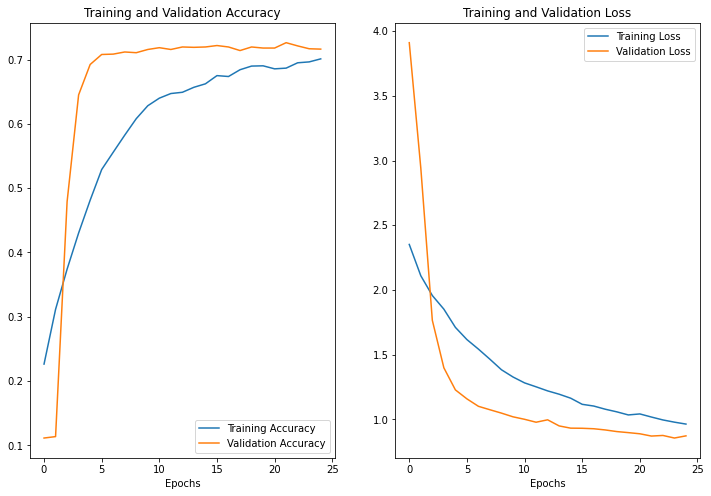

In [37]:
print_training_history(history)